import numpy as np
import matplotlib.pyplot as plt
import openai
import os
from tqdm import tqdm
import torch
import llmlex
import pandas as pd
import sympy as sp

In [1]:
import numpy as np
import openai
import llmlex
import matplotlib.pyplot as plt
import time

In [2]:
funcs = [
            lambda x: (x**3.),
            lambda x: (51.2288 * np.cos((1.18219 * x))),
            lambda x: x,
            lambda x: (4.01209 + np.exp(x)),
        ]

print(len(funcs))

4


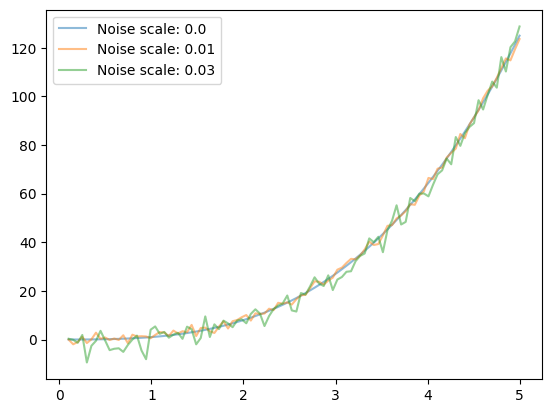

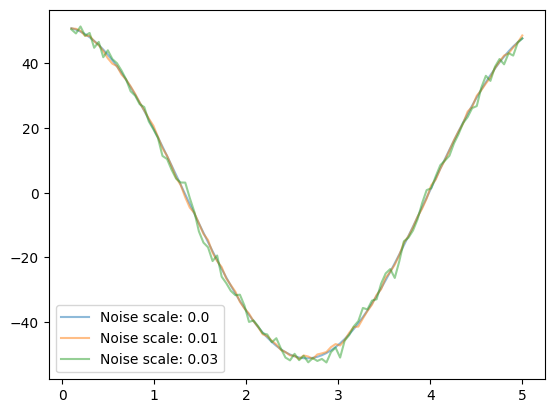

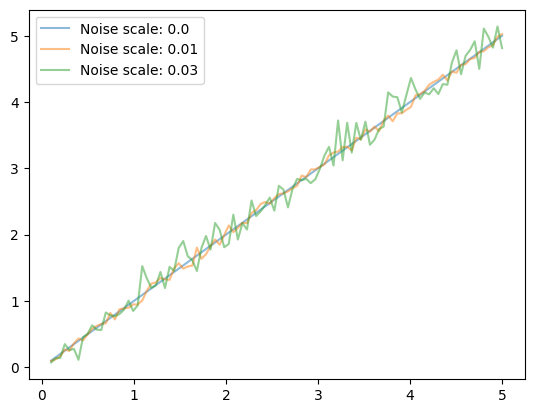

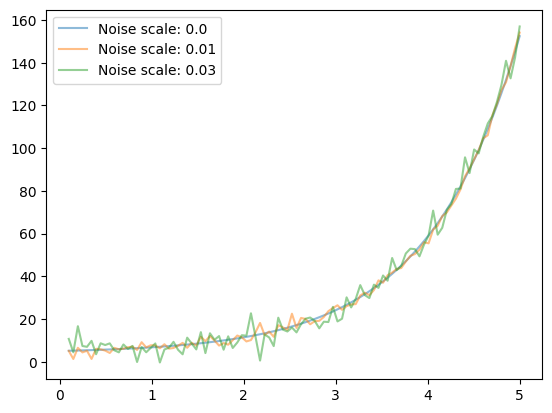

In [3]:
xVals = np.linspace(0.1, 5, 100)
noise_scales = [0., .01, .03]
for func in funcs:
    y = func(xVals)
    for noise_scale in noise_scales:
        noise = np.max(np.abs(y))*np.random.normal(0, noise_scale, xVals.shape)
        y_noisy = y + noise

        plt.plot(xVals, y_noisy, label=f'Noise scale: {noise_scale}', alpha=0.5)
    plt.legend()
    plt.show()

In [4]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

# Run 1

## Search

In [5]:
xVals = np.linspace(0.1, 5, 100)
count = 0
population_size = 25
num_of_generations = 10
res_list = []

noise_scales = [0., .01, .03]
try:
    import pickle
    with open(f"fit_functions_with_noise.pkl", 'rb') as f:
        res_list, compute_times, noises = pickle.load(f)
    print("Results already computed. Exiting.")

except FileNotFoundError:
    compute_times, noises = [], []
    for func in funcs:
        print(f"Function {count}")
        count+=1
        for noise_scale in noise_scales:
            start_time = time.time()
            y = func(xVals)
            noise = np.max(np.abs(y))*np.random.normal(0, noise_scale, xVals.shape)
            noises.append(noise)
            y = y + noise
            fig, ax = plt.subplots()
            plt.xticks([xVals[0], xVals[-1]], ['%2.f' % xVals[0], '%2.f' % xVals[-1]])
            plt.yticks([min(y), max(y)], ['%2.f' % min(y), '%2.f' % max(y)])
            base64_image = llmlex.images.generate_base64_image(fig, ax, xVals, y)
            plt.show()
            start = llmlex.llm.check_key_limit(client)
            res = llmlex.run_genetic(client, base64_image, xVals, y, population_size,num_of_generations, 
                                    temperature=1., model="openai/gpt-4o", system_prompt=None, elite=True, use_async=True, exit_condition=1e-2) #1e-7)
            res_list.append(res)
            compute_times.append(time.time() - start_time)
            print(f"Credits spent: {start - llmlex.llm.check_key_limit(client)}")


Results already computed. Exiting.


## Compare

Function 0
params[0] + params[1] * np.power(x, 2) + params[2] * np.power(x, 3)
[-8.52163273e-09  6.35674857e-09  9.99999999e-01]
-2.6594862235011975e-19


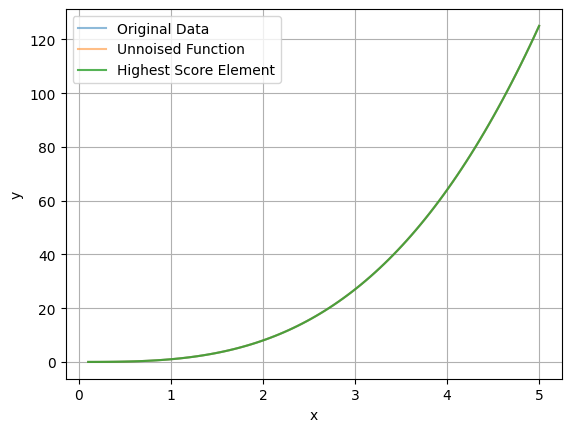

Function 1
params[0] * np.exp(params[1] * x) + params[2]
[ 5.07293549  0.66035188 -8.88686148]
-0.01884092390537262


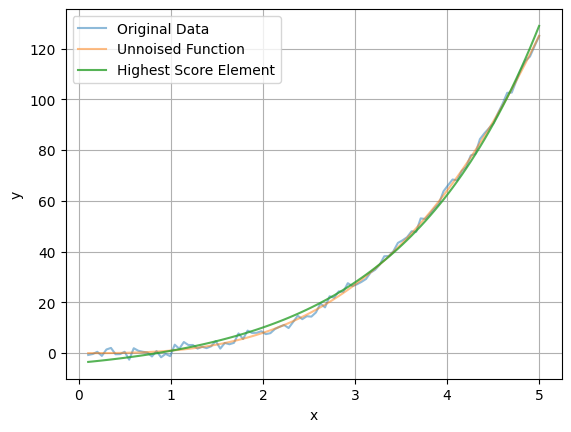

Function 2
params[0] * np.exp(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4] * x + params[5] + params[6] * np.sin(params[7] * x) + params[8] * np.log(params[9] + x)
[ 5.57057407e+02  3.92182749e-02  5.30277641e+00 -6.28516596e+01
  4.46682409e+02  3.19601025e+02  4.88276936e+00  1.88694151e+00
 -1.11479034e+03  2.18445162e+00]
-0.05610266700387001


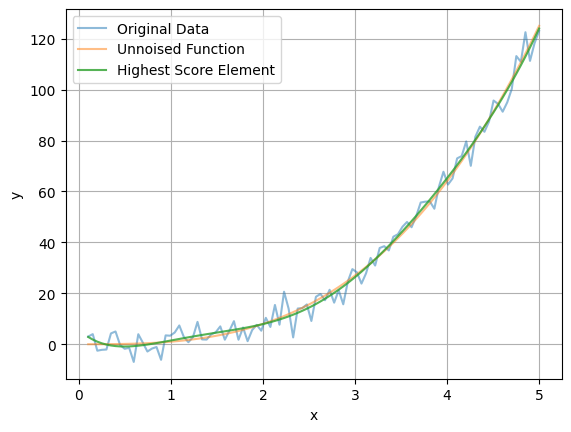

Function 3
params[0] * np.cos(params[1] * x + params[2])
[ 51.2288       1.18219    -12.56637061]
-4.491368782429724e-31


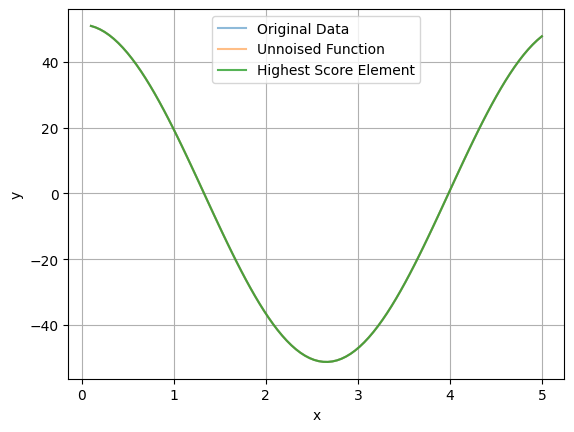

Function 4
params[0] * np.cos(params[1] * x) + params[2] * np.sin(params[3] * x) + params[4]
[ 5.11316606e+01  1.18194243e+00  1.30909600e-01  1.85320421e+00
 -3.22987180e-02]
-0.00022565785911865532


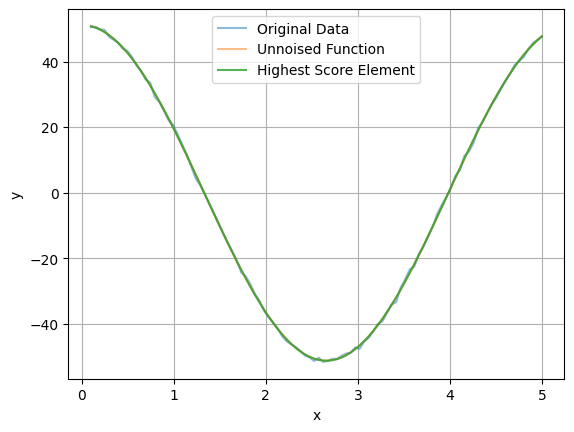

Function 5
params[0] * np.cos(params[1] * x + params[2]) + params[3] * x**2 + params[4] * x + params[5]
[ 85.38683138   1.0208444  -30.99104722  -8.97908369  47.88058455
 -29.64136012]
-0.001874365727417171


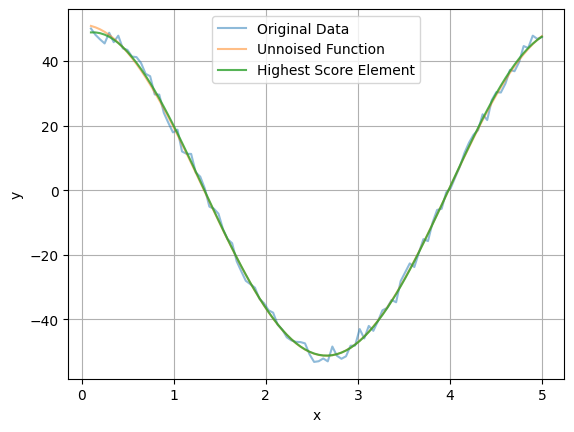

Function 6
params[0] * x
[1.]
-0.0


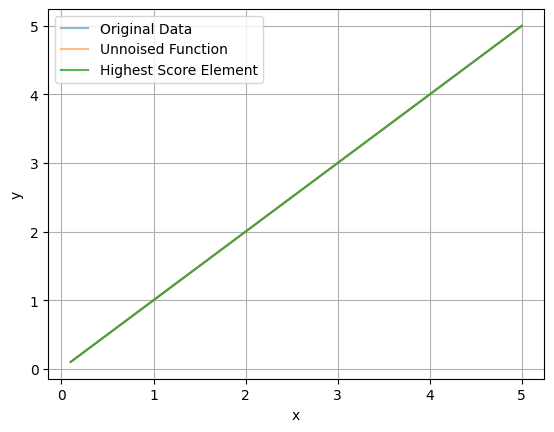

Function 7
params[0] * x + params[1]
[ 1.00809297 -0.01979199]
-0.0015655966708436608


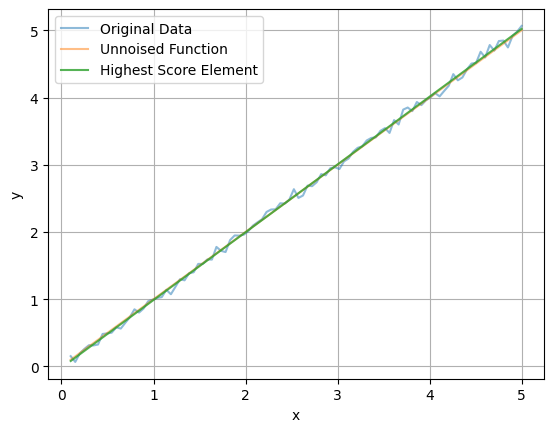

Function 8
params[0] * x + params[1] + params[2] * np.sin(params[3] * x)
[  2.1722221    0.05321281 -11.16156631   0.1093514 ]
-0.015192420221865177


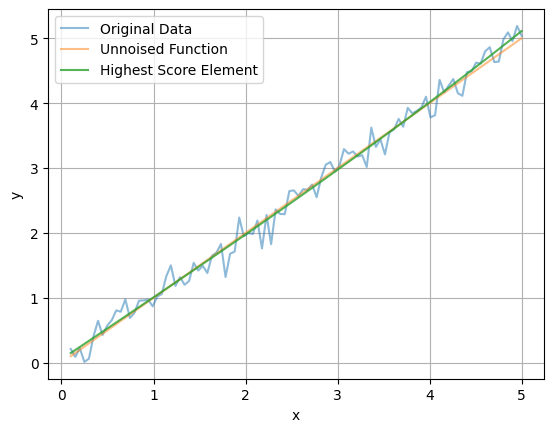

Function 9
params[0] * np.exp(params[1] * x) + params[2]
[1.      1.      4.01209]
-3.3721483554468376e-30


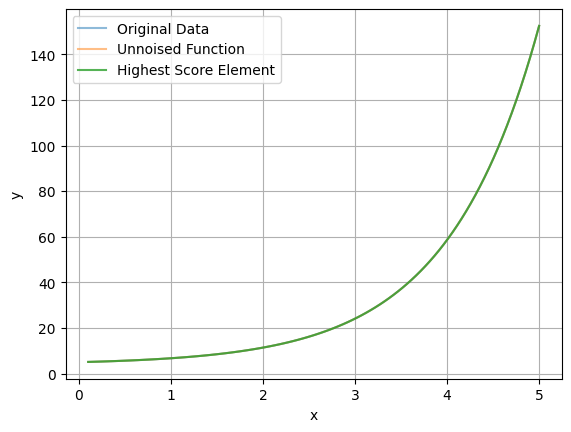

Function 10
params[0] * np.exp(params[1] * x) + params[2]
[1.01373936 0.99761371 3.98897905]
-0.020811542868614197


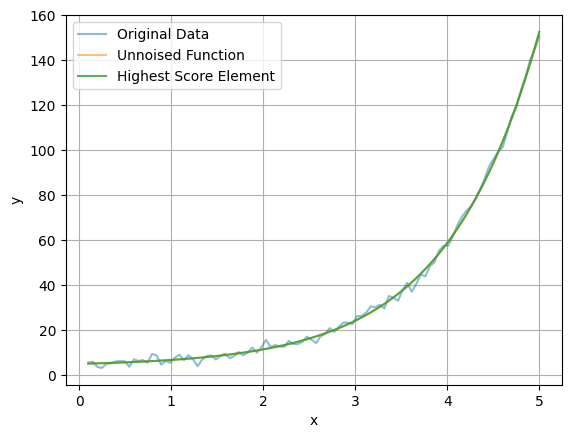

Function 11
params[0] * np.exp(params[1] * x) + params[2] * x**3 + params[3] * x**2 + params[4] * x + params[5] * np.sin(params[6] * x) + params[7] * np.log(params[8] + x)
[  10.16683397    0.76347175   -6.23481183   41.90751124 -191.2753424
   -1.08512791   -3.0634578   212.70290672    0.93257658]
-0.09998808056116104


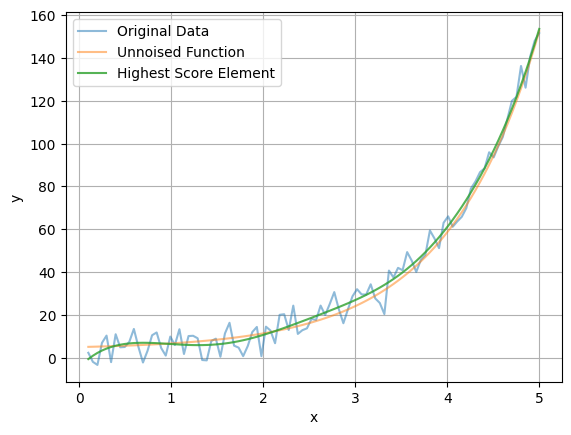

In [6]:
for index in range(len(res_list)):
    print(f"Function {index}")
    y = funcs[index//3](xVals)
    y_true = y
    noise = noises[index]
    y = y + noise
    res = res_list[index]
    highest_score_element = max((item for sublist in res for item in sublist), key=lambda item: item['score'])
    print(highest_score_element['ansatz'])
    print(highest_score_element['params'])
    print(highest_score_element['score'])

    # Extract the parameters and the ansatz function from the highest_score_element
    params = highest_score_element['params']
    ansatz = highest_score_element['ansatz']

    # Define the ansatz function
    def ansatz_function(x, params):
        return eval(ansatz)

    # Plot the original data
    plt.plot(xVals, y, label='Original Data', alpha=0.5)

    # Plot the unnoised function
    plt.plot(xVals, y_true, label='Unnoised Function', alpha=0.5)

    # Plot the highest score element
    plt.plot(xVals, ansatz_function(xVals, params), label='Highest Score Element', alpha=0.8)

    # Add labels and legend
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
all_results = [res_list, compute_times, noises]
# Save the results to a file
import pickle
with open(f'fit_functions_with_noise.pkl', 'wb') as f:
    pickle.dump(all_results, f)

# Single Shot

In [ ]:
for func in funcs:
    print(f"Function {count}")
    count+=1
    for noise_scale in noise_scales:
        print("Noise scale: ", noise_scale)
        start_time = time.time()
        y = func(xVals)
        noise = 0. * np.max(np.abs(y))*np.random.normal(0, noise_scale, xVals.shape)
        noises.append(noise)
        y = y + noise
        fig, ax = plt.subplots()
        plt.xticks([xVals[0], xVals[-1]], ['%2.f' % xVals[0], '%2.f' % xVals[-1]])
        plt.yticks([min(y), max(y)], ['%2.f' % min(y), '%2.f' % max(y)])
        base64_image = llmlex.images.generate_base64_image(fig, ax, xVals, y)
        r = llmlex.single_call(client, base64_image, xVals, y, model="openai/gpt-4o")

        print(r['params'], r['ansatz'], r['score'])



Function 0
Noise scale:  0.0


2025-05-08 12:41:18,041 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * np.exp(params[1] * x) with 2 parameters
2025-05-08 12:41:18,238 - LLMLEx.llmlex - INFO - Fit result: score=-0.047783125191926956, params=[2.36366341 0.80678471]


[2.36366341 0.80678471] params[0] * np.exp(params[1] * x) -0.047783125191926956
Noise scale:  0.01


2025-05-08 12:41:21,381 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] + params[1] * np.square(x) with 2 parameters
2025-05-08 12:41:21,382 - LLMLEx.llmlex - INFO - Fit result: score=-0.1349163055419922, params=[-8.20389301  4.72870143]


[-8.20389301  4.72870143] params[0] + params[1] * np.square(x) -0.1349163055419922
Noise scale:  0.03


2025-05-08 12:41:23,503 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * np.exp(params[1] * x) with 2 parameters
2025-05-08 12:41:23,505 - LLMLEx.llmlex - INFO - Fit result: score=-0.047783125191926956, params=[2.36366341 0.80678471]


[2.36366341 0.80678471] params[0] * np.exp(params[1] * x) -0.047783125191926956
Function 1
Noise scale:  0.0


2025-05-08 12:41:26,131 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * np.cos(params[1] * x + params[2]) + pa... with 4 parameters
2025-05-08 12:41:26,136 - LLMLEx.llmlex - INFO - Fit result: score=-4.3089456073165365e-17, params=[5.12288003e+01 1.18218999e+00 2.76118120e-08 5.46939991e-07]


[5.12288003e+01 1.18218999e+00 2.76118120e-08 5.46939991e-07] params[0] * np.cos(params[1] * x + params[2]) + params[3] -4.3089456073165365e-17
Noise scale:  0.01


2025-05-08 12:41:32,579 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * np.cos(params[1] * x + params[2]) + pa... with 4 parameters
2025-05-08 12:41:32,581 - LLMLEx.llmlex - INFO - Fit result: score=-4.3089456073165365e-17, params=[5.12288003e+01 1.18218999e+00 2.76118120e-08 5.46939991e-07]


[5.12288003e+01 1.18218999e+00 2.76118120e-08 5.46939991e-07] params[0] * np.cos(params[1] * x + params[2]) + params[3] -4.3089456073165365e-17
Noise scale:  0.03


2025-05-08 12:41:38,364 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * np.cos(params[1] * x + params[2]) + pa... with 4 parameters
2025-05-08 12:41:38,369 - LLMLEx.llmlex - INFO - Fit result: score=-4.3089456073165365e-17, params=[5.12288003e+01 1.18218999e+00 2.76118120e-08 5.46939991e-07]


[5.12288003e+01 1.18218999e+00 2.76118120e-08 5.46939991e-07] params[0] * np.cos(params[1] * x + params[2]) + params[3] -4.3089456073165365e-17
Function 2
Noise scale:  0.0


2025-05-08 12:41:41,963 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * x + params[1] with 2 parameters
2025-05-08 12:41:41,969 - LLMLEx.llmlex - INFO - Fit result: score=-4.964730281725029e-19, params=[9.99999999e-01 1.78211355e-09]


[9.99999999e-01 1.78211355e-09] params[0] * x + params[1] -4.964730281725029e-19
Noise scale:  0.01


2025-05-08 12:41:43,770 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * x + params[1] with 2 parameters
2025-05-08 12:41:43,776 - LLMLEx.llmlex - INFO - Fit result: score=-4.964730281725029e-19, params=[9.99999999e-01 1.78211355e-09]


[9.99999999e-01 1.78211355e-09] params[0] * x + params[1] -4.964730281725029e-19
Noise scale:  0.03


2025-05-08 12:41:46,302 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] * x + params[1] with 2 parameters
2025-05-08 12:41:46,307 - LLMLEx.llmlex - INFO - Fit result: score=-4.964730281725029e-19, params=[9.99999999e-01 1.78211355e-09]


[9.99999999e-01 1.78211355e-09] params[0] * x + params[1] -4.964730281725029e-19
Function 3
Noise scale:  0.0


2025-05-08 12:41:52,753 - LLMLEx.llmlex - INFO - Extracted ansatz: params[0] + params[1]*x**2 with 2 parameters
2025-05-08 12:41:52,758 - LLMLEx.llmlex - INFO - Fit result: score=-1.1754122972488403, params=[-5.96015473  4.73891653]


[-5.96015473  4.73891653] params[0] + params[1]*x**2 -1.1754122972488403
Noise scale:  0.01
